In [1]:
using Printf, CSV, DataFrames, Statistics, Glob, XLSX, Dates, Plots, TimeSeries, JSON, Distributions, ExpectationMaximization

In [2]:
data_directory = joinpath("/projects", "emco4286", "data", "gads", "trajectories", "cc")
files = glob("gen_*_class_CC_rating_*_state_Texas.csv", data_directory)

264-element Vector{String}:
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_3_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 ⋮
 "/projects/emco4286/data/gads/tr" ⋯ 25 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 25 bytes ⋯ "ass_CC_rating_1_st

In [39]:
ph = 8760
foh = 741.35
num_fo = 6.14
poh = 769.13
num_po = 1.08
moh = 291.4
num_mo = 2.04

fo_rate = (ph - moh - poh)/num_fo
po_rate = (ph - moh - foh)/num_po
mo_rate = (ph - foh - poh)/num_mo

3553.6862745098038

In [100]:
ttf_values_fo_vec = Any[]
ttr_values_fo_vec = Any[]

ttf_values_po_vec = Any[]
ttr_values_po_vec = Any[]

ttf_values_mo_vec = Any[]
ttr_values_mo_vec = Any[]

for f in files

    df = DataFrame(CSV.File(f))

    if size(df)[1] < 1
        continue
    end

    outage_start = findall(diff(df[!, :y1]) .== -1)
    outage_end = findall(diff(df[!, :y1]) .== 1)

    if length(outage_end) < length(outage_start)
        outage_start = outage_start[begin: end-1]
    elseif length(outage_end) > length(outage_start)
        outage_end = outage_end[begin + 1: end]
    end

    ttr_values = outage_end .- outage_start
    ttf_values_all_types = outage_start[begin + 1: end] - outage_end[begin:end - 1]

    outage_types = df[outage_end, :y2]
    
    fo_idx = findall(outage_types .== 2)
    os_fo = outage_start[fo_idx]
    oe_fo = outage_end[fo_idx]

    fo_idx_mod = filter(x -> x > 0, fo_idx .- 1)

    ttf_values_fo = ttf_values_all_types[fo_idx_mod]
    ttr_values_fo = ttr_values[fo_idx]

    push!(ttf_values_fo_vec, ttf_values_fo)
    push!(ttr_values_fo_vec, ttr_values_fo)

    po_idx = findall(outage_types .== 3)
    os_po = outage_start[po_idx]
    oe_po = outage_end[po_idx]

    po_idx_mod = filter(x -> x > 0, po_idx .- 1)

    ttf_values_po = ttf_values_all_types[po_idx_mod]
    ttr_values_po = ttr_values[po_idx]

    push!(ttf_values_po_vec, ttf_values_po)
    push!(ttr_values_po_vec, ttr_values_po)

    mo_idx = findall(outage_types .== 4)
    os_mo = outage_start[mo_idx]
    oe_mo = outage_end[mo_idx]

    mo_idx_mod = filter(x -> x > 0, mo_idx .- 1)

    ttf_values_mo = ttf_values_all_types[mo_idx_mod]
    # ttf_values_mo = os_mo[begin + 1: end] - oe_mo[begin:end - 1]
    ttr_values_mo = ttr_values[mo_idx]

    push!(ttf_values_mo_vec, ttf_values_mo)
    push!(ttr_values_mo_vec, ttr_values_mo)

end
    

In [101]:
ttr_values_fo_vec = reduce(vcat, ttr_values_fo_vec)
ttr_values_po_vec = reduce(vcat, ttr_values_po_vec)
ttr_values_mo_vec = reduce(vcat, ttr_values_mo_vec)

ttr_f = fit_mle(Exponential(mean(ttr_values_fo_vec)), ttr_values_fo_vec)
ttr_p = fit_mle(Exponential(mean(ttr_values_po_vec)), ttr_values_po_vec)
ttr_m = fit_mle(Exponential(mean(ttr_values_mo_vec)), ttr_values_mo_vec)

Exponential{Float64}(θ=130.37614678899084)

In [102]:
ttf_values_fo_vec = reduce(vcat, ttf_values_fo_vec)
ttf_values_po_vec = reduce(vcat, ttf_values_po_vec)
ttf_values_mo_vec = reduce(vcat, ttf_values_mo_vec)

848-element Vector{Int64}:
 7768
 4791
  466
  178
   28
  466
 1847
   22
 2014
 1897
    ⋮
  452
  301
   55
  377
 1581
  957
   68
  136
  999

In [103]:
fo_rate_guess = fit_mle(Exponential(fo_rate), ttf_values_fo_vec)
po_rate_guess = fit_mle(Exponential(po_rate), ttf_values_po_vec)
mo_rate_guess = fit_mle(Exponential(mo_rate), ttf_values_mo_vec)

Exponential{Float64}(θ=733.2653301886793)

In [104]:
all_ttf = reduce(vcat, [ttf_values_fo_vec, ttf_values_po_vec, ttf_values_mo_vec])

4447-element Vector{Int64}:
 1842
  688
 4150
 1796
 1255
  593
 3334
 2760
 1529
  594
    ⋮
  452
  301
   55
  377
 1581
  957
   68
  136
  999

In [105]:
mix_guess = MixtureModel([fo_rate_guess, po_rate_guess, mo_rate_guess], [1/3, 1/3, 1/3])
mix_mle, info = fit_mle(mix_guess, all_ttf, infos = true)

(MixtureModel{Exponential{Float64}}(K = 3)
components[1] (prior = 0.1416): Exponential{Float64}(θ=17.485603061230503)
components[2] (prior = 0.4075): Exponential{Float64}(θ=1565.5037688676757)
components[3] (prior = 0.4509): Exponential{Float64}(θ=297.8818408114037)
, Dict{String, Any}("iterations" => 129, "converged" => true, "logtots" => [-33575.39240694486, -33387.48135607607, -33303.10997148516, -33258.524764980575, -33221.41849794905, -33186.67264453568, -33156.38599607871, -33132.6183606934, -33115.41751432487, -33103.354017707796  …  -32983.12020802005, -32983.11848638047, -32983.11688945418, -32983.11540827397, -32983.11403451023, -32983.11276042645, -32983.111578837576, -32983.11048307139, -32983.10946693241, -32983.10852466832]))

In [96]:
mix_mle.components

3-element Vector{Exponential{Float64}}:
 Exponential{Float64}(θ=19.299399967192173)
 Exponential{Float64}(θ=4125.469414857861)
 Exponential{Float64}(θ=494.16934168992697)

In [106]:
samples = rand(mix_mle, 4327)

4327-element Vector{Float64}:
  119.4766076310666
  313.19378165830307
  986.6208493592745
   57.4831201998518
  392.28623765480353
    9.073119381441874
  108.84603323518792
   66.15538725585031
   19.633066373780903
 1666.1937875416033
    ⋮
  171.46814555652637
 4965.374621656388
  320.5586297028211
    1.9818539499135346
 1835.6770476794472
 1016.1260804529004
 5021.924418135286
    7.9399721150758875
   39.92328979188437

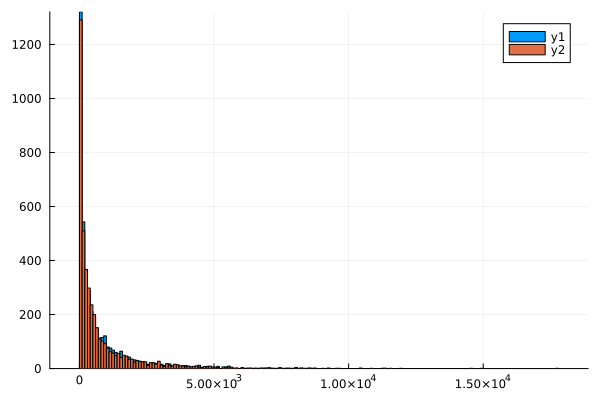

In [108]:
histogram([all_ttf, samples])